## The Annotated Construct and Reducer Functions

In [2]:
from langgraph.graph import START, END, StateGraph, add_messages
from typing_extensions import TypedDict
from langchain_ollama import ChatOllama
from langchain_core.messages import AIMessage, HumanMessage, BaseMessage
from collections.abc import Sequence
from typing import Literal, Annotated

### Get Familiar with the add_messages Function

In [4]:
my_list = add_messages([HumanMessage("Hi! I'm Oscar."), 
                        AIMessage("Hey, Oscar. How can I assist you?")],
                       [HumanMessage("Could you summarize today's news?")])

my_list

[HumanMessage(content="Hi! I'm Oscar.", additional_kwargs={}, response_metadata={}, id='e97caf94-05a4-4e26-9900-f4538befaf2a'),
 AIMessage(content='Hey, Oscar. How can I assist you?', additional_kwargs={}, response_metadata={}, id='e877d7c9-11e3-4b21-a7a7-fb189e0b32ca'),
 HumanMessage(content="Could you summarize today's news?", additional_kwargs={}, response_metadata={}, id='d592e292-a07f-4f50-9fae-fd655bc61989')]

### Define the State

In [5]:
class State(TypedDict):
    messages: Annotated[Sequence[BaseMessage], add_messages]

### Define the Nodes

In [6]:
import os
os.environ.setdefault("no_proxy", "127.0.0.1,localhost")
os.environ.setdefault("HTTPX_NO_PROXY", "127.0.0.1,localhost")
OLLAMA_URL = os.getenv("OLLAMA_URL", "http://127.0.0.1:11434")

model_name = "gemma3" #"llama3.2:3b"

max_tokens = 100
llm = ChatOllama(model=model_name, num_predict=max_tokens, temperature=0)

In [ ]:
def ask_question(state: State) -> State:

    print(f"\n-------> ENTERING ask_question:")
    for i in state["messages"]:
        i.pretty_print()

    question = "What is your question?"
    print(question)

    return State(messages = [AIMessage(question), HumanMessage(input())])

In [ ]:
def chatbot(state: State) -> State:

    print(f"\n-------> ENTERING chatbot:")
    for i in state["messages"]:
        i.pretty_print()

    response = llm.invoke(state["messages"])
    response.pretty_print()

    return State(messages = [response])

In [16]:
def ask_another_question(state: State) -> State:

    print(f"\n-------> ENTERING ask_another_question:")
    for i in state["messages"]:
        i.pretty_print()

    question = "Would you like to ask one more question (yes/no)?"
    print(question)

    return State(messages = [AIMessage(question), HumanMessage(input())])

### Define the Routing Function

In [17]:
def routing_function(state: State) -> Literal["ask_question", "__end__"]:

    if state["messages"][-1].content == "yes":
        return "ask_question"
    else:
        return "__end__"

### Define the Graph

In [18]:
graph = StateGraph(State)

In [19]:
graph.add_node("ask_question", ask_question)
graph.add_node("chatbot", chatbot)
graph.add_node("ask_another_question", ask_another_question)

graph.add_edge(START, "ask_question")
graph.add_edge("ask_question", "chatbot")
graph.add_edge("chatbot", "ask_another_question")
graph.add_conditional_edges(source = "ask_another_question", 
                            path = routing_function)

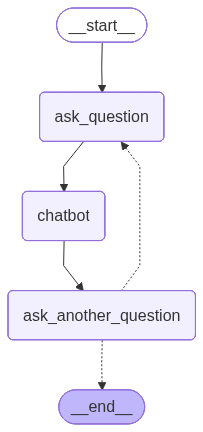

In [20]:
graph_compiled = graph.compile()
graph_compiled

### Test the Graph

In [22]:
graph_compiled.invoke(State(messages = []))


-------> ENTERING ask_question:
What is your question?

-------> ENTERING chatbot:
================================== Ai Message ==================================

The capital of Iran is **Tehran**. 

It's the country's largest city and political, cultural, and economic center. 😊 

Do you want to know anything more about Tehran or Iran in general?

-------> ENTERING ask_another_question:
================================ Human Message =================================

What's the capital of Iran?
================================== Ai Message ==================================

The capital of Iran is **Tehran**. 

It's the country's largest city and political, cultural, and economic center. 😊 

Do you want to know anything more about Tehran or Iran in general?
Would you like to ask one more question (yes/no)?


{'messages': [HumanMessage(content="What's the capital of Iran?", additional_kwargs={}, response_metadata={}, id='55835ca7-dc96-463e-a14c-79c9893bd494'),
  AIMessage(content="The capital of Iran is **Tehran**. \n\nIt's the country's largest city and political, cultural, and economic center. 😊 \n\nDo you want to know anything more about Tehran or Iran in general?", additional_kwargs={}, response_metadata={'model': 'gemma3', 'created_at': '2025-11-18T07:17:25.3135167Z', 'done': True, 'done_reason': 'stop', 'total_duration': 5546377000, 'load_duration': 324031600, 'prompt_eval_count': 17, 'prompt_eval_duration': 211819000, 'eval_count': 47, 'eval_duration': 4974845900, 'model_name': 'gemma3'}, id='run--2cc17bf2-8c0d-4f8f-bded-eb244307e3fe-0', usage_metadata={'input_tokens': 17, 'output_tokens': 47, 'total_tokens': 64}),
  AIMessage(content='Would you like to ask one more question (yes/no)?', additional_kwargs={}, response_metadata={}, id='8636b223-3138-489a-b417-7da850596f42'),
  HumanMes